<a href="https://colab.research.google.com/github/gmitt98/Ames-Housing-ML/blob/main/Ames_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from scipy import stats
import plotly.express as px
import seaborn as sns

In [10]:
# add the case shiller price index to the data in order to incorporate national price trends
ames = 'https://bootcamp-proj-4.s3.us-west-1.amazonaws.com/AmesHousing.csv'
case_shiller = 'https://bootcamp-proj-4.s3.us-west-1.amazonaws.com/cs_index_us.csv'

ames_df = pd.read_csv(ames)
cs_df = pd.read_csv(case_shiller)

In [11]:
ames_df = ames_df.merge(cs_df, left_on = 'Yr Sold', right_on = 'Year', how = 'left')
ames_df.drop(columns = ['Year'], inplace = True)

### Data Cleaning & Feature Engineering (sort of)

In [12]:
numerical_features = ames_df.select_dtypes(include=[np.number]).columns.tolist()
for feature in numerical_features:
    ames_df[feature].fillna(ames_df[feature].median(), inplace=True)

In [13]:
categorical_features = ames_df.select_dtypes(include=[np.object]).columns.tolist()
for feature in categorical_features:
    ames_df[feature].fillna('None', inplace=True)

<ipython-input-13-f9aa48ba4269>:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  categorical_features = ames_df.select_dtypes(include=[np.object]).columns.tolist()


In [14]:
ames_df['Total SF'] = ames_df['Total Bsmt SF'] + ames_df['1st Flr SF'] + ames_df['2nd Flr SF']

In [15]:
# Look for outliers
fig = px.scatter(ames_df, x='Gr Liv Area', y='SalePrice', hover_name=ames_df.index)

# Calculate R^2 value for the trendline
X = ames_df['Gr Liv Area']
y = ames_df['SalePrice']
p = np.polyfit(X, y, 1)  # get linear fit parameters
y_fit = np.polyval(p, X)  # compute y values using the fit
r2 = r2_score(y, y_fit)

# Add annotation for R^2 value on the plot
fig.add_annotation(
    x=np.max(X) * 0.6,
    y=np.min(y_fit),
    text=f"R^2 = {r2:.4f}",
    showarrow=False
)
fig.show()

In [16]:
ames_df=ames_df[ames_df['Gr Liv Area']<4000]

In [17]:
fig = px.scatter(ames_df, x='Gr Liv Area', y='SalePrice', hover_name=ames_df.index)

# Calculate R^2 value for the trendline
X = ames_df['Gr Liv Area']
y = ames_df['SalePrice']
p = np.polyfit(X, y, 1)  # get linear fit parameters
y_fit = np.polyval(p, X)  # compute y values using the fit
r2 = r2_score(y, y_fit)

# Add annotation for R^2 value on the plot
fig.add_annotation(
    x=np.max(X) * 0.6,
    y=np.min(y_fit),
    text=f"R^2 = {r2:.4f}",
    showarrow=False
)

fig.show()

In [18]:
# Now we encode
ames_df = pd.get_dummies(ames_df)

### Feature Scaling

In [19]:
scaler = StandardScaler()
ames_df[numerical_features] = scaler.fit_transform(ames_df[numerical_features])

### Model Training

In [20]:
X = ames_df.drop('SalePrice', axis=1)  # All columns except target variable
y = ames_df['SalePrice']  # Target variable

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Linear Regression

In [22]:
# Create and fit Linear Regerssion model to training set
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on test (or validation set)
y_pred_lr = model.predict(X_test)

# Print R-Squared and MSE
print(f"Training R-Squared: {model.score(X_train, y_train):.4f}")
print(f"Testing R-Squared: {model.score(X_test, y_test):.4f}")
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred_lr):.4f}")

Training R-Squared: 0.9401
Testing R-Squared: 0.9397
Mean Squared Error: 0.0695


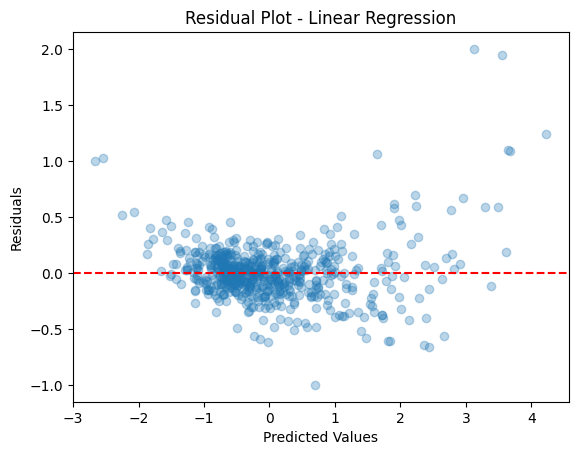

In [23]:
# Residuals plot
residuals_lr = y_test - y_pred_lr
plt.scatter(y_pred_lr, residuals_lr, alpha = 0.3)
plt.axhline(y = 0, color = "red", linestyle = '--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot - Linear Regression')
plt.show()

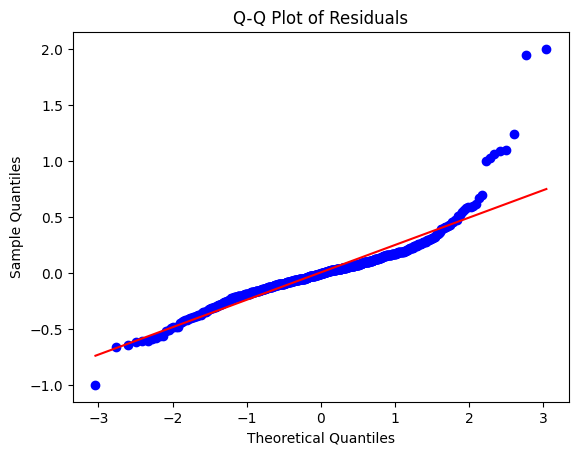

In [24]:
# Q-Q Plot
stats.probplot(residuals_lr, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.show()

Gradient Boosting

In [25]:
from warnings import filterwarnings
filterwarnings('ignore')

# Create a Gradient Boosting Regressor
model = GradientBoostingRegressor(random_state=42)

# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 1.0],
    'loss': ['ls', 'lad', 'huber']
}

# Perform grid search cross-validation
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Get the best parameters and the best model from the grid search
best_params = grid_search.best_params_

# Train a model using the best parameters
best_model = GradientBoostingRegressor(random_state=42, **best_params)
best_model.fit(X_train, y_train)

print(f"Best Parameters: {best_params}")

# Make predictions on the test set
y_pred = best_model.predict(X_test)

print(f"Training R-Squared: {best_model.score(X_train, y_train)}")
print(f"Testing R-Squared: {best_model.score(X_test, y_test)}")
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))

Best Parameters: {'learning_rate': 0.1, 'loss': 'huber', 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}
Training R-Squared: 0.9676501961674518
Testing R-Squared: 0.9501703258657423
Mean Squared Error: 0.05743137013095087


Results:

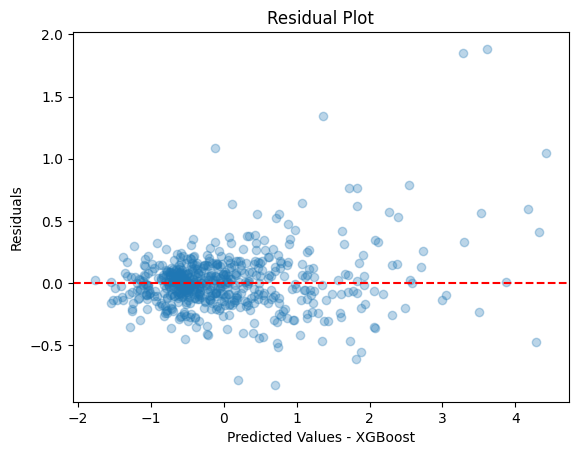

In [26]:
# Residuals Plot
residuals = y_test - y_pred
plt.scatter(y_pred, residuals, alpha = 0.3)
plt.axhline(y = 0, color = "red", linestyle = '--')
plt.xlabel('Predicted Values - XGBoost')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

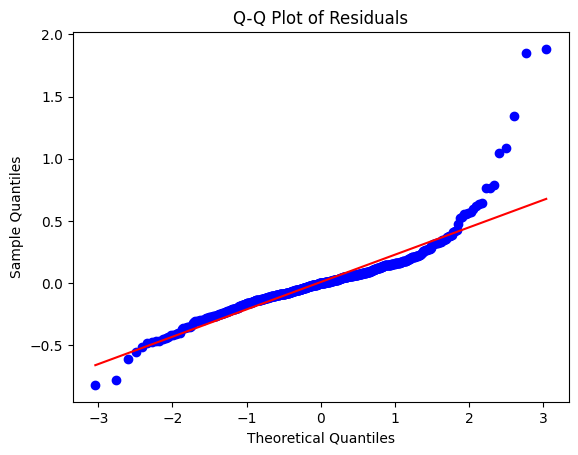

In [27]:
# Q-Q Plot
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.show()

Length of y_pred: 585
Length of y_test: 585


<Axes: ylabel='SalePrice'>

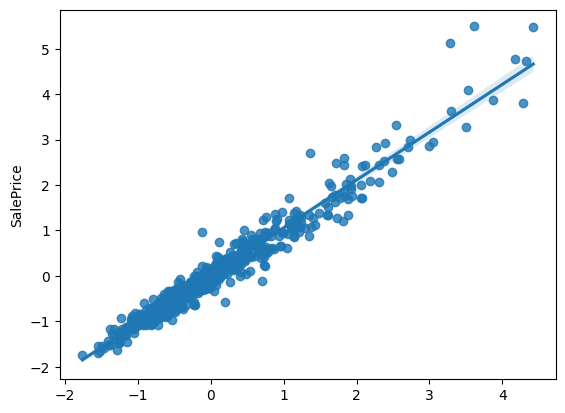

In [28]:
print("Length of y_pred:", len(y_pred))
print("Length of y_test:", len(y_test))

pred_values = {"y_pred": y_pred,
"y_test": y_test}
pred_dataframe = pd.DataFrame(pred_values)

# predictive visual
fig2 = px.scatter(pred_dataframe, x='y_pred', y='y_test', title='Predicted vs Actual Y Values')
fig2.show()

sns.regplot(x="y_pred", y="y_test", data=pred_values)

In [40]:
importances = best_model.feature_importances_


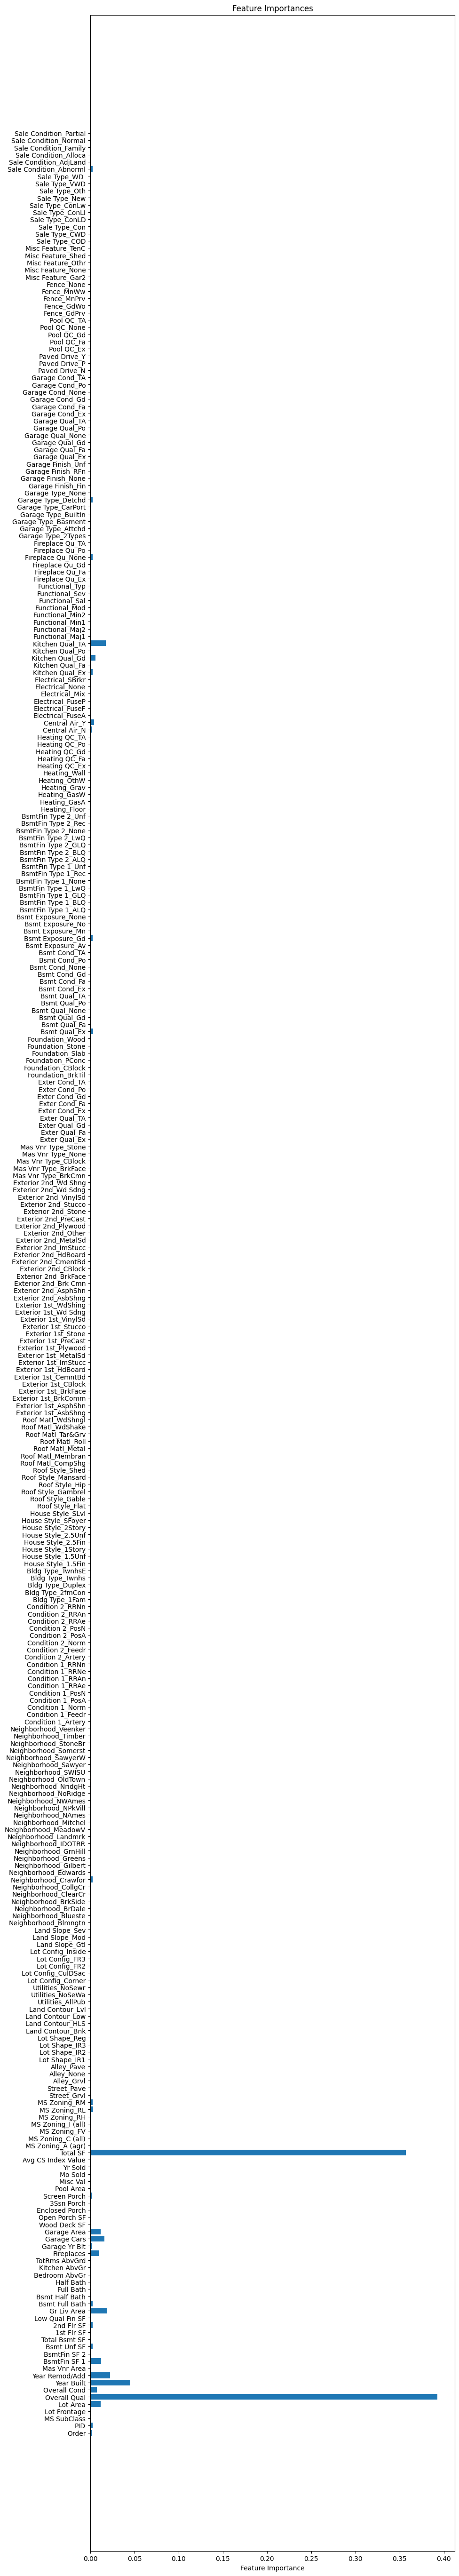

In [38]:
feature_names = X.columns
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 70))
plt.barh(range(len(importances)), importances)
plt.yticks(range(len(importances)), [feature_names[i] for i in range(len(importances))])
plt.xlabel('Feature Importance')
plt.title('Feature Importances')
plt.show()